In [1]:
#    This file is part of DEAP.
#
#    DEAP is free software: you can redistribute it and/or modify
#    it under the terms of the GNU Lesser General Public License as
#    published by the Free Software Foundation, either version 3 of
#    the License, or (at your option) any later version.
#
#    DEAP is distributed in the hope that it will be useful,
#    but WITHOUT ANY WARRANTY; without even the implied warranty of
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
#    GNU Lesser General Public License for more details.
#
#    You should have received a copy of the GNU Lesser General Public
#    License along with DEAP. If not, see <http://www.gnu.org/licenses/>.

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)

import array, copy, random, time
# import logging
import numpy as np
import pandas as pd
import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')

# imports for the BNN
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle

from deap import algorithms, base, creator, tools


# load min and max values of the data to denormalize prediction data
with open('maxmin.pickle', 'rb') as f:
    [max_x, min_x, max_y, min_y] = pickle.load(f)

def normalize_max_min(data, data_max, data_min):
    return (data-data_min) / (data_max-data_min)

def denormalize_max_min(data, data_max, data_min):
    return data * (data_max-data_min) + data_min

class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, 2 * output_dim)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer3(x)

        return x

# # load BL model BNN
# toolbox.model = torch.load('BNN_BLmodel.pt')
    
def evaluate(vars):

    # load BL model BNN
    BL_model = torch.load('BNN_BLmodel.pt')

    max_part_height = 4.2   # maximum part height mm

    # number of total layers = (maximum part height)/(height of a layer), i.e., 4.2 / (layer height)
    if vars[2] == 1:
        height = 0.42
    elif vars[2] == 2:
        height = 0.6
    elif vars[2] == 3:
        height = 0.7

    num_layers = np.int(max_part_height / height); # number of layers

    num_interfaces = 14     # number of interfaces per layer
    width = 0.8             # filament width in mm

    inp = [] # input to BNN to make predictions
    ycoord = 0.5 * height  # 0.5*height of a layer in mm
    iki_y = ycoord * 2

    # store inputs for GP(model disrepancy at each interface)
    for jj in range(1, num_layers + 1):
        for ii in range(1, num_interfaces + 1):
            # use x & y coordinates of vertical bonds as training data for the GP
            # Inp =[ Temperature, speed, height, x, y ]
            inp.append([vars[0], vars[1], height, ii * width, ycoord + (jj - 1) * iki_y])

    # Convert built Python lists to a Numpy array.
    inp = np.array(inp, dtype='float32')

    # normalize data
    inp = normalize_max_min(inp, max_x, min_x)

    x_pred = torch.tensor(inp)  # convert to torch tensor

    samples = []
    noises = []
    for i in range(15):
        preds = BL_model.forward(x_pred).cpu().data.numpy()
        samples.append(denormalize_max_min(preds[:, 0], max_y, min_y))
        noises.append(denormalize_max_min(np.exp(preds[:, 1]), max_y, min_y))

    samples, noises = np.array(samples),  np.array(noises)
    means = (samples.mean(axis=0)).reshape(-1)

    aleatoric = (noises ** 2).mean(axis=0) ** 0.5
    epistemic = (samples.var(axis=0) ** 0.5).reshape(-1)
    total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5

    # Dimensionless BL: non-dimensionalize the BL by dividing with the layer height
    dimensionless_mean_bl = means.mean()/height
    dimensionless_total_unc_bl = total_unc.mean()/height**2

    return dimensionless_mean_bl, dimensionless_total_unc_bl


IND_SIZE = 3
N_CYCLES = 1
BOUND_LOW, BOUND_UP = [217, 26, 1], [278, 44, 3]

creator.create("FitnessMin", base.Fitness, weights=(1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin, n=IND_SIZE)

toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_temperature", random.randint, 217, 278)
toolbox.register("attr_speed", random.randint, 26, 44)
toolbox.register("attr_layer", random.randint, 1, 3)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_temperature,toolbox.attr_speed,toolbox.attr_layer), n=N_CYCLES)


# Structure initializers
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def checkBounds(min, max):
    def decorator(func):
        def wrappper(*args, **kargs):
            offspring = func(*args, **kargs)
            for child in offspring:
                for i in range(len(child)):
                    if child[i] > max[i]:
                        child[i] = max[i]
                    elif child[i] < min[i]:
                        child[i] = min[i]
            return offspring
        return wrappper
    return decorator

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxUniform, indpb=1.0/IND_SIZE)
toolbox.register("mutate", tools.mutUniformInt, low=BOUND_LOW, up=BOUND_UP, indpb=1.0/IND_SIZE)
toolbox.register("select", tools.selNSGA2)

# Bounds on the design variables
toolbox.decorate("mate", checkBounds([217, 26, 1], [278, 44, 3]))
toolbox.decorate("mutate", checkBounds([217, 26, 1], [278, 44, 3]))

toolbox.mut_prob = 0.2  # mutation probability

def run_ea(toolbox, stats=None, verbose=False):
    pop = toolbox.population(n=toolbox.pop_size)
    pop = toolbox.select(pop, len(pop))
    return algorithms.eaMuPlusLambda(pop, toolbox, mu=toolbox.pop_size, 
                                     lambda_=toolbox.pop_size, 
                                     cxpb=1-toolbox.mut_prob,
                                     mutpb=toolbox.mut_prob, 
                                     stats=stats, 
                                     ngen=toolbox.max_gen, 
                                     verbose=verbose)


stats = tools.Statistics()
stats.register("pop", copy.deepcopy)

toolbox.pop_size = 50
toolbox.max_gen = 100
toolbox.mut_prob = 0.2

%time pop, logbook = run_ea(toolbox, stats=stats)



C:\Users\berkc\Miniconda3\envs\Research_AM_2020\lib\site-packages\torch\serialization.py:420: UserWarning: Couldn't retrieve source code for container of type MC_Dropout_Model. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "


Wall time: 13min 22s


## Hypervolume computation

In [2]:
fronts = [tools.sortLogNondominated(pop, k=len(pop), first_front_only=True) 
          for pop in logbook.select('pop')]

In [3]:
# reference = np.max([np.max([ind.fitness.values for ind in front], axis=0) for front in fronts], axis=0) + [-0.8, 0.8]
reference = np.max([np.max([ind.fitness.values for ind in front], axis=0) for front in fronts], axis=0) + [-0.4, 0.]
print(reference)

[0.49231928 0.26213242]


In [4]:
import deap.benchmarks.tools as bt

In [5]:
hypervols = [bt.hypervolume(front, reference) for front in fronts]

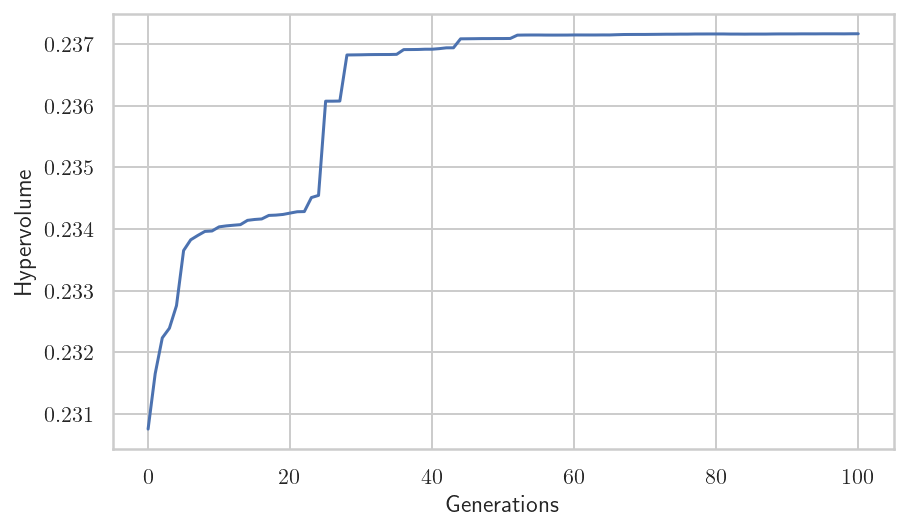

In [6]:
plt.figure(figsize=(7, 4))
plt.plot(hypervols)
# plt.title('Hypervolume of the non-dominated fronts')
plt.xlabel('Generations')
plt.ylabel('Hypervolume');

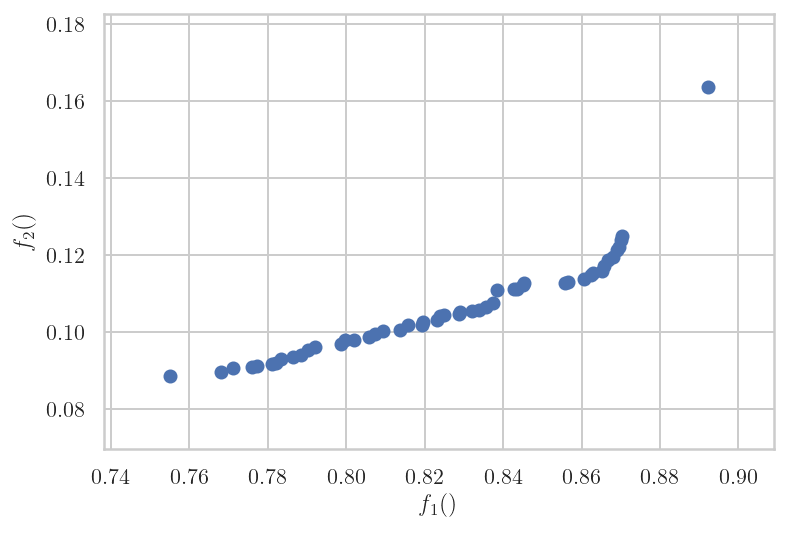

In [7]:
front = np.array([ind.fitness.values for ind in pop])
plt.scatter(front[:,0], front[:,1], c="b")
plt.axis("tight")
plt.xlabel('$f_1()$')
plt.ylabel('$f_2()$')
plt.show()

# Calculating performance indicators
- As already mentioned, we need to evaluate the quality of the solutions produced in every execution of the algorithm.
- We will use the hypervolumne indicator for that.
- Larger hypervolume values are better.
- We already filtered each population a leave only the non-dominated individuals.

Calculating the reference point: a point that is “worst” than any other individual in every objective.

In [8]:
# def calculate_reference(results, epsilon=0.1):
#     alldata = np.concatenate(np.concatenate(results.values))
#     obj_vals = [toolbox.evaluate(ind) for ind in alldata]
#     return np.max(obj_vals, axis=0) + epsilon

In [9]:
# reference = calculate_reference(res)

Compute hypervolume of the Pareto-optimal fronts